2023-07-13 12:00:30,081 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2023-07-13 12:00:51,510 solvers 0/1 INFO :: Stop iteration reached.


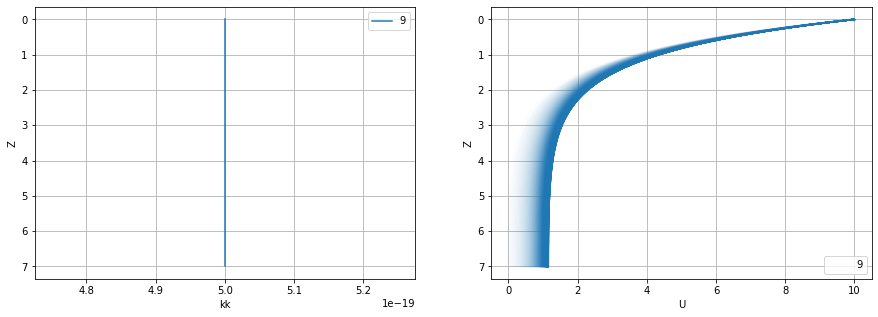

In [7]:
import numpy as np
import time
import scipy.special as sp
import matplotlib.pyplot as plt

from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits

import logging
logger = logging.getLogger(__name__)

# Bases and domain # interval = (ln(1e8/1e8), ln(1e11/1e8)) - normalised pressures
x_basis = de.Chebyshev('x', 256, interval=(0, 7), dealias=3/2) # resolution = 256
domain = de.Domain([x_basis], np.float64)

finaltt = 1e21 # total dimensional time in s
dtstep = 1e2 # timestep size in s
tau0 = 1e14 # scaling for time in s
tauF = 3e20 # rayleigh drag timescale in s
uF = 10.0 # magnitude of velocity forcing at the top in cm/s
# l = 1/7e10 # horizontal wavenumber
# f = 5.4e-6 # Coriolis freq
# R = 3.1e7 # Gas constant

# implementation of domain dependent radiative diffusion
ktan= 10 # defines steepness of 0-1 transition in x=0
def Heavyside(x): # step function
    return 0.5*(1. + np.tanh(ktan*x))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
# drange = [0,1,2]
crange = [9] # list of transition locations
# the value '4' would imply transition at 4 scale heights; see plot of''kk'
lor = 0; d = 1
for idx,c in enumerate(crange): # location of transition in log pressure, see plot below    
    x = domain.grid(0)
    K_K = 5e-19 # modified radiative diffusion, k = 1/(L_d * l)**2/tau_R
    kk = domain.new_field(name='kkk') # 
#     kk['g'] =  K_K - K_K * c * x / 35  
    kk['g'] =  K_K * Heavyside(c - x) + d / 10 * K_K * (1 - Heavyside(c - x))

    ax1.plot(kk['g'],x) # plotting the variation of k
    
    # Problem
    problem = de.IVP(domain, variables=['u', 'ux'])
    problem.parameters['tau0'] = tau0
    problem.parameters['tauF'] = tauF
    problem.parameters['k'] = kk 
    problem.add_equation("dt(u) + u * tau0 / tauF - tau0 * dx(k * ux) - k * tau0 * ux  = 0") # k_z not requried, same as above equation
    problem.add_equation("ux - dx(u) = 0")
    problem.add_bc("left(u) = 1.0") # forcing boundary condition at the top, nondimensional
    problem.add_bc("right(ux) = 0.0") # free shear botton boundary condition

    # Build solver
    solver = problem.build_solver(de.timesteppers.SBDF2)
    solver.stop_wall_time = np.inf
    solver.stop_iteration = int(finaltt/tau0/dtstep) # n_iter = total time / dimentional time unit / timestep size

    # Initial conditions
    x = domain.grid(0)
    u = solver.state['u']
    ux = solver.state['ux']

    u['g'] = np.exp(-100*x) # differentiable initial condition
    u['g'] = 0 # nondifferentiable initial condition, still works fine because of implicit implementation
    u.differentiate(0, out=ux)

    # Store data for final plot
    u.set_scales(1)
    ux.set_scales(1)
    u_list = [np.copy(u['g'])]
    ux_list = [np.copy(ux['g'])]
    t_list = [solver.sim_time]

    # Time integration
    dt = dtstep
    chu = 0
    try:
        # logger.info('Starting loop')
        start_time = time.time()
        while solver.proceed:
            solver.step(dt)
            if solver.iteration % 1000 == 0:
                u.set_scales(1)
                u_list.append(np.copy(u['g']))
                ux_list.append(np.copy(ux['g']))
                t_list.append(solver.sim_time)
            if solver.iteration % 1000 == 0:
                # logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration,solver.sim_time, dt))
                chu = chu + 1
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        end_time = time.time()

    u_array = np.array(u_list) # output 
    ux_array = np.array(ux_list)
    t_array = np.array(t_list)
    cmap = plt.get_cmap("tab10")
    for i in range(0,chu): # plots time varying zonal vel profiles with different transparency
        ax2.plot(u_array[i,:]*uF,x,color=cmap(lor), alpha = (i+1)/chu)
    lor = lor + 1
#     ax2.plot(u_array[-1,:]*uF,x,color=cmap(idx)) # plots final zonal velocity profile
    
ax1.set(xlabel='kk', ylabel='Z')
ax1.legend(crange)
ax1.grid()
ax1.invert_yaxis()

ax2.set(xlabel='U', ylabel='Z')
ax2.legend(crange)
ax2.grid()
ax2.invert_yaxis()

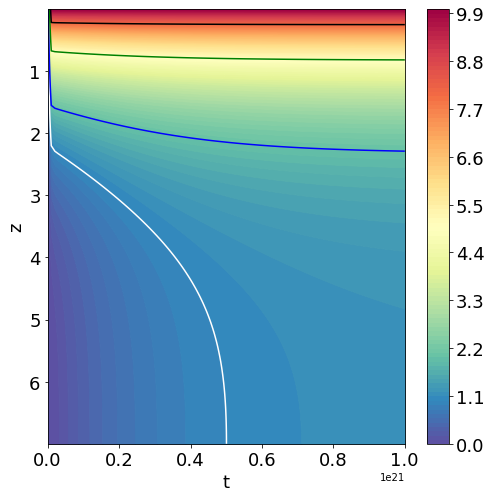

In [8]:
# plots contours in a spacetime diagram to show degree of penetration
X, T = np.meshgrid(x, t_array)
plt.figure(figsize=(8,8))
plt.gca().tick_params(axis = 'both', which = 'major', labelsize = 18)
CS=plt.contour(T * tau0, X, u_array * uF, levels=[1, 2, 5, 8], colors=['w','b','g','k'],linewidths=1.5)
plt.xlabel('t',fontsize=18)
plt.ylabel('z',fontsize=18)
CP = plt.contourf(T * tau0, X, u_array * uF,cmap='Spectral_r', levels =100)
for c in CP.collections:
        c.set_edgecolor("face")
cbar=plt.colorbar()
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)
plt.gca().invert_yaxis()